## dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
# nltk.download('stopwords')
warnings.filterwarnings("ignore", category=DeprecationWarning) 
%matplotlib inline
sns.set()

### import dataset

In [2]:
targetset = pd.read_csv('output/hotel_review_data.csv')
len(targetset)

10000

### There are cities named the same in multiple states. Need to combine to make unique.

In [3]:
targetset["city_and_state"] = targetset["city"] + ", " + targetset["province"]

### checking how many reviews are associated with which cities. Machine learning will not work if there isn't enough data.

In [4]:
targetset["city_and_state"].value_counts()

San Diego, CA        1189
San Francisco, CA     808
New Orleans, LA       798
Atlanta, GA           762
Orlando, FL           734
                     ... 
Bardstown, KY           1
Eastland, TX            1
Idabel, OK              1
Willows, CA             1
Washington, NC          1
Name: city_and_state, Length: 893, dtype: int64

### curating out low review counts 

In [5]:
cutoff = targetset.groupby("city_and_state").filter(lambda x:len(x)>10)
len(cutoff)
cutoff["city"].value_counts()

San Diego          1189
San Francisco       808
New Orleans         798
Atlanta             762
Orlando             734
                   ... 
King of Prussia      11
Arlington            11
Harrisburg           11
Raton                11
Santa Monica         11
Name: city, Length: 64, dtype: int64

In [6]:
cutoff.head()

,id,address,city,country,latitude,longitude,name,postalCode,province,reviews_rating,reviews_sourceURLs,reviews_text,reviews_title,city_and_state
5,6,167 W Main St,Lexington,US,38.047014,-84.497742,21c Museum Hotel Lexington,40507,KY,4,http://www.tripadvisor.com/Hotel_Review-g39588...,"This is such a fun, lovely hotel. The attentio...",Loved staying here,"Lexington, KY"
6,7,167 W Main St,Lexington,US,38.047014,-84.497742,21c Museum Hotel Lexington,40507,KY,1,https://www.tripadvisor.com/Hotel_Review-g3958...,We recently stayed at this hotel on a trip to ...,Does not live up to its reputation,"Lexington, KY"
8,9,2240 Buena Vista Rd,Lexington,US,38.042100,-84.427100,Microtel Inn Suites By Wyndham Lexington,40505,KY,5,https://www.tripadvisor.co.uk/Hotel_Review-g39...,MoreMore,Location Location Location,"Lexington, KY"
10,11,1953 Nicholasville Rd,Lexington,US,38.012430,-84.516350,Hampton Inn Lexington Medical Center,40503,KY,5,https://www.tripadvisor.com/Hotel_Review-g3958...,This is a new Hampton Inn and is well decorate...,Beautiful hotel,"Lexington, KY"
13,14,610 Poydras St,New Orleans,US,29.949125,-90.069748,The Whitney Hotel,70130,LA,3,https://www.tripadvisor.com/Hotel_Review-g6086...,The water is very hot and there's no cold wate...,"Very hot water, bad food","New Orleans, LA"


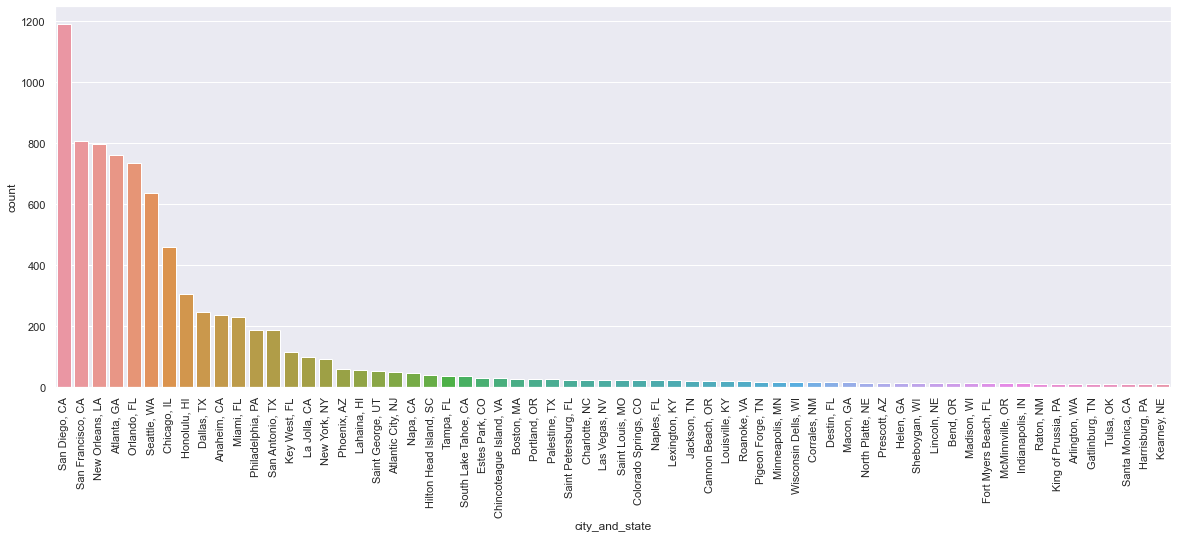

In [7]:
xaxis = cutoff.city_and_state.value_counts().index.tolist()
fig1 = plt.subplots(figsize = (20,7))
sns.countplot(x='city_and_state', data=cutoff, order = xaxis)
plt.xticks(rotation = 90)
plt.show()

### NLP PROCESSING

In [8]:
from utils import preprocess_text
cutoff["reviews_text_tokens"] = cutoff["reviews_text"].apply(lambda x: preprocess_text(x, min_word_length=4))
cutoff.head()

,id,address,city,country,latitude,longitude,name,postalCode,province,reviews_rating,reviews_sourceURLs,reviews_text,reviews_title,city_and_state,reviews_text_tokens
5,6,167 W Main St,Lexington,US,38.047014,-84.497742,21c Museum Hotel Lexington,40507,KY,4,http://www.tripadvisor.com/Hotel_Review-g39588...,"This is such a fun, lovely hotel. The attentio...",Loved staying here,"Lexington, KY","[lovely, hotel, attention, detail, impressive,..."
6,7,167 W Main St,Lexington,US,38.047014,-84.497742,21c Museum Hotel Lexington,40507,KY,1,https://www.tripadvisor.com/Hotel_Review-g3958...,We recently stayed at this hotel on a trip to ...,Does not live up to its reputation,"Lexington, KY","[recently, stay, hotel, trip, lexington, frien..."
8,9,2240 Buena Vista Rd,Lexington,US,38.042100,-84.427100,Microtel Inn Suites By Wyndham Lexington,40505,KY,5,https://www.tripadvisor.co.uk/Hotel_Review-g39...,MoreMore,Location Location Location,"Lexington, KY",[moremore]
10,11,1953 Nicholasville Rd,Lexington,US,38.012430,-84.516350,Hampton Inn Lexington Medical Center,40503,KY,5,https://www.tripadvisor.com/Hotel_Review-g3958...,This is a new Hampton Inn and is well decorate...,Beautiful hotel,"Lexington, KY","[hampton, decorate, color, scheme, give, feel,..."
13,14,610 Poydras St,New Orleans,US,29.949125,-90.069748,The Whitney Hotel,70130,LA,3,https://www.tripadvisor.com/Hotel_Review-g6086...,The water is very hot and there's no cold wate...,"Very hot water, bad food","New Orleans, LA","[water, cold, water, awful, food, good, staff,..."


In [9]:
from utils import preprocess_text
cutoff["reviews_text_tokens"] = cutoff["reviews_text"].apply(lambda x : ' '.join(preprocess_text(x, min_word_length=4)))
cutoff.head()

,id,address,city,country,latitude,longitude,name,postalCode,province,reviews_rating,reviews_sourceURLs,reviews_text,reviews_title,city_and_state,reviews_text_tokens
5,6,167 W Main St,Lexington,US,38.047014,-84.497742,21c Museum Hotel Lexington,40507,KY,4,http://www.tripadvisor.com/Hotel_Review-g39588...,"This is such a fun, lovely hotel. The attentio...",Loved staying here,"Lexington, KY",lovely hotel attention detail impressive thick...
6,7,167 W Main St,Lexington,US,38.047014,-84.497742,21c Museum Hotel Lexington,40507,KY,1,https://www.tripadvisor.com/Hotel_Review-g3958...,We recently stayed at this hotel on a trip to ...,Does not live up to its reputation,"Lexington, KY",recently stay hotel trip lexington friend grou...
8,9,2240 Buena Vista Rd,Lexington,US,38.042100,-84.427100,Microtel Inn Suites By Wyndham Lexington,40505,KY,5,https://www.tripadvisor.co.uk/Hotel_Review-g39...,MoreMore,Location Location Location,"Lexington, KY",moremore
10,11,1953 Nicholasville Rd,Lexington,US,38.012430,-84.516350,Hampton Inn Lexington Medical Center,40503,KY,5,https://www.tripadvisor.com/Hotel_Review-g3958...,This is a new Hampton Inn and is well decorate...,Beautiful hotel,"Lexington, KY",hampton decorate color scheme give feel luxury...
13,14,610 Poydras St,New Orleans,US,29.949125,-90.069748,The Whitney Hotel,70130,LA,3,https://www.tripadvisor.com/Hotel_Review-g6086...,The water is very hot and there's no cold wate...,"Very hot water, bad food","New Orleans, LA",water cold water awful food good staff friendl...


In [10]:
### Preprocessing, stemming, tokenizing

import string
string.punctuation
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
#punc = ['.', ',', '"', '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
# punc = string.punctuation
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

desc = cutoff["reviews_text"].values
desc2 = cutoff["reviews_text_tokens"].values
# vectorizer = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize, max_features = 2000)
vectorizer = TfidfVectorizer(tokenizer = tokenize, max_features = 2000)
X = vectorizer.fit_transform(desc2)
word_features = vectorizer.get_feature_names()
# word_features[:50]

In [11]:
len(word_features)

2000

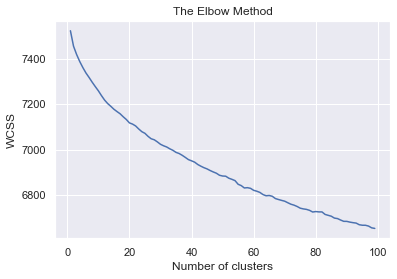

<Figure size 2160x2160 with 0 Axes>

In [20]:
##Estimating the best K value to use for clustering using the Elbow Method
# https://en.wikipedia.org/wiki/Elbow_method_(clustering)

### THIS CALCULATION TAKES APPROX 3+ HOURS TO RUN ###

from sklearn.cluster import KMeans
wcss = []
for i in range(1,100):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=100,n_init=10,random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,100),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow.png')
plt.figure(figsize = (30, 30))
plt.show()

In [12]:
### No good K value located based on Elbow Method. Picking 25 for time constraints

kmeans = KMeans(n_clusters = 25)
kmeans.fit(X)

KMeans(n_clusters=25)

In [13]:
### Listing out the 10 most common words per cluster

common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(word_features[word] for word in centroid))

0 : whitney, callaisgener, casey, orlean, sincer, hotel, manag, visit, stay, forward
1 : quarter, french, hotel, orlean, room, street, stay, walk, great, bourbon
2 : ritz, carlton, stay, atlanta, hotel, servic, valet, room, great, club
3 : room, hotel, area, stay, night, breakfast, small, floor, walk, .the
4 : great, staff, help, stay, friend, hotel, clean, room, breakfast, locat
5 : western, diego, best, stay, hotel, thank, plus, room, staff, breakfast
6 : room, shower, bathroom, smell, hotel, door, water, dirti, stay, wall
7 : thank, stay, hotel, time, enjoy, review, great, staff, back, room
8 : atlanta, stay, hotel, downtown, staff, locat, great, room, buckhead, area
9 : airport, orlando, garden, hilton, shuttl, stay, hotel, servic, guest, managerhilton
10 : distanc, walk, within, restaur, hotel, locat, stay, great, room, nice
11 : union, squar, francisco, hotel, room, locat, stay, walk, great, staff
12 : room, stay, night, hotel, check, staff, book, clean, arriv, even
13 : love, pl

In [15]:
cutoff['cluster'] = kmeans.labels_

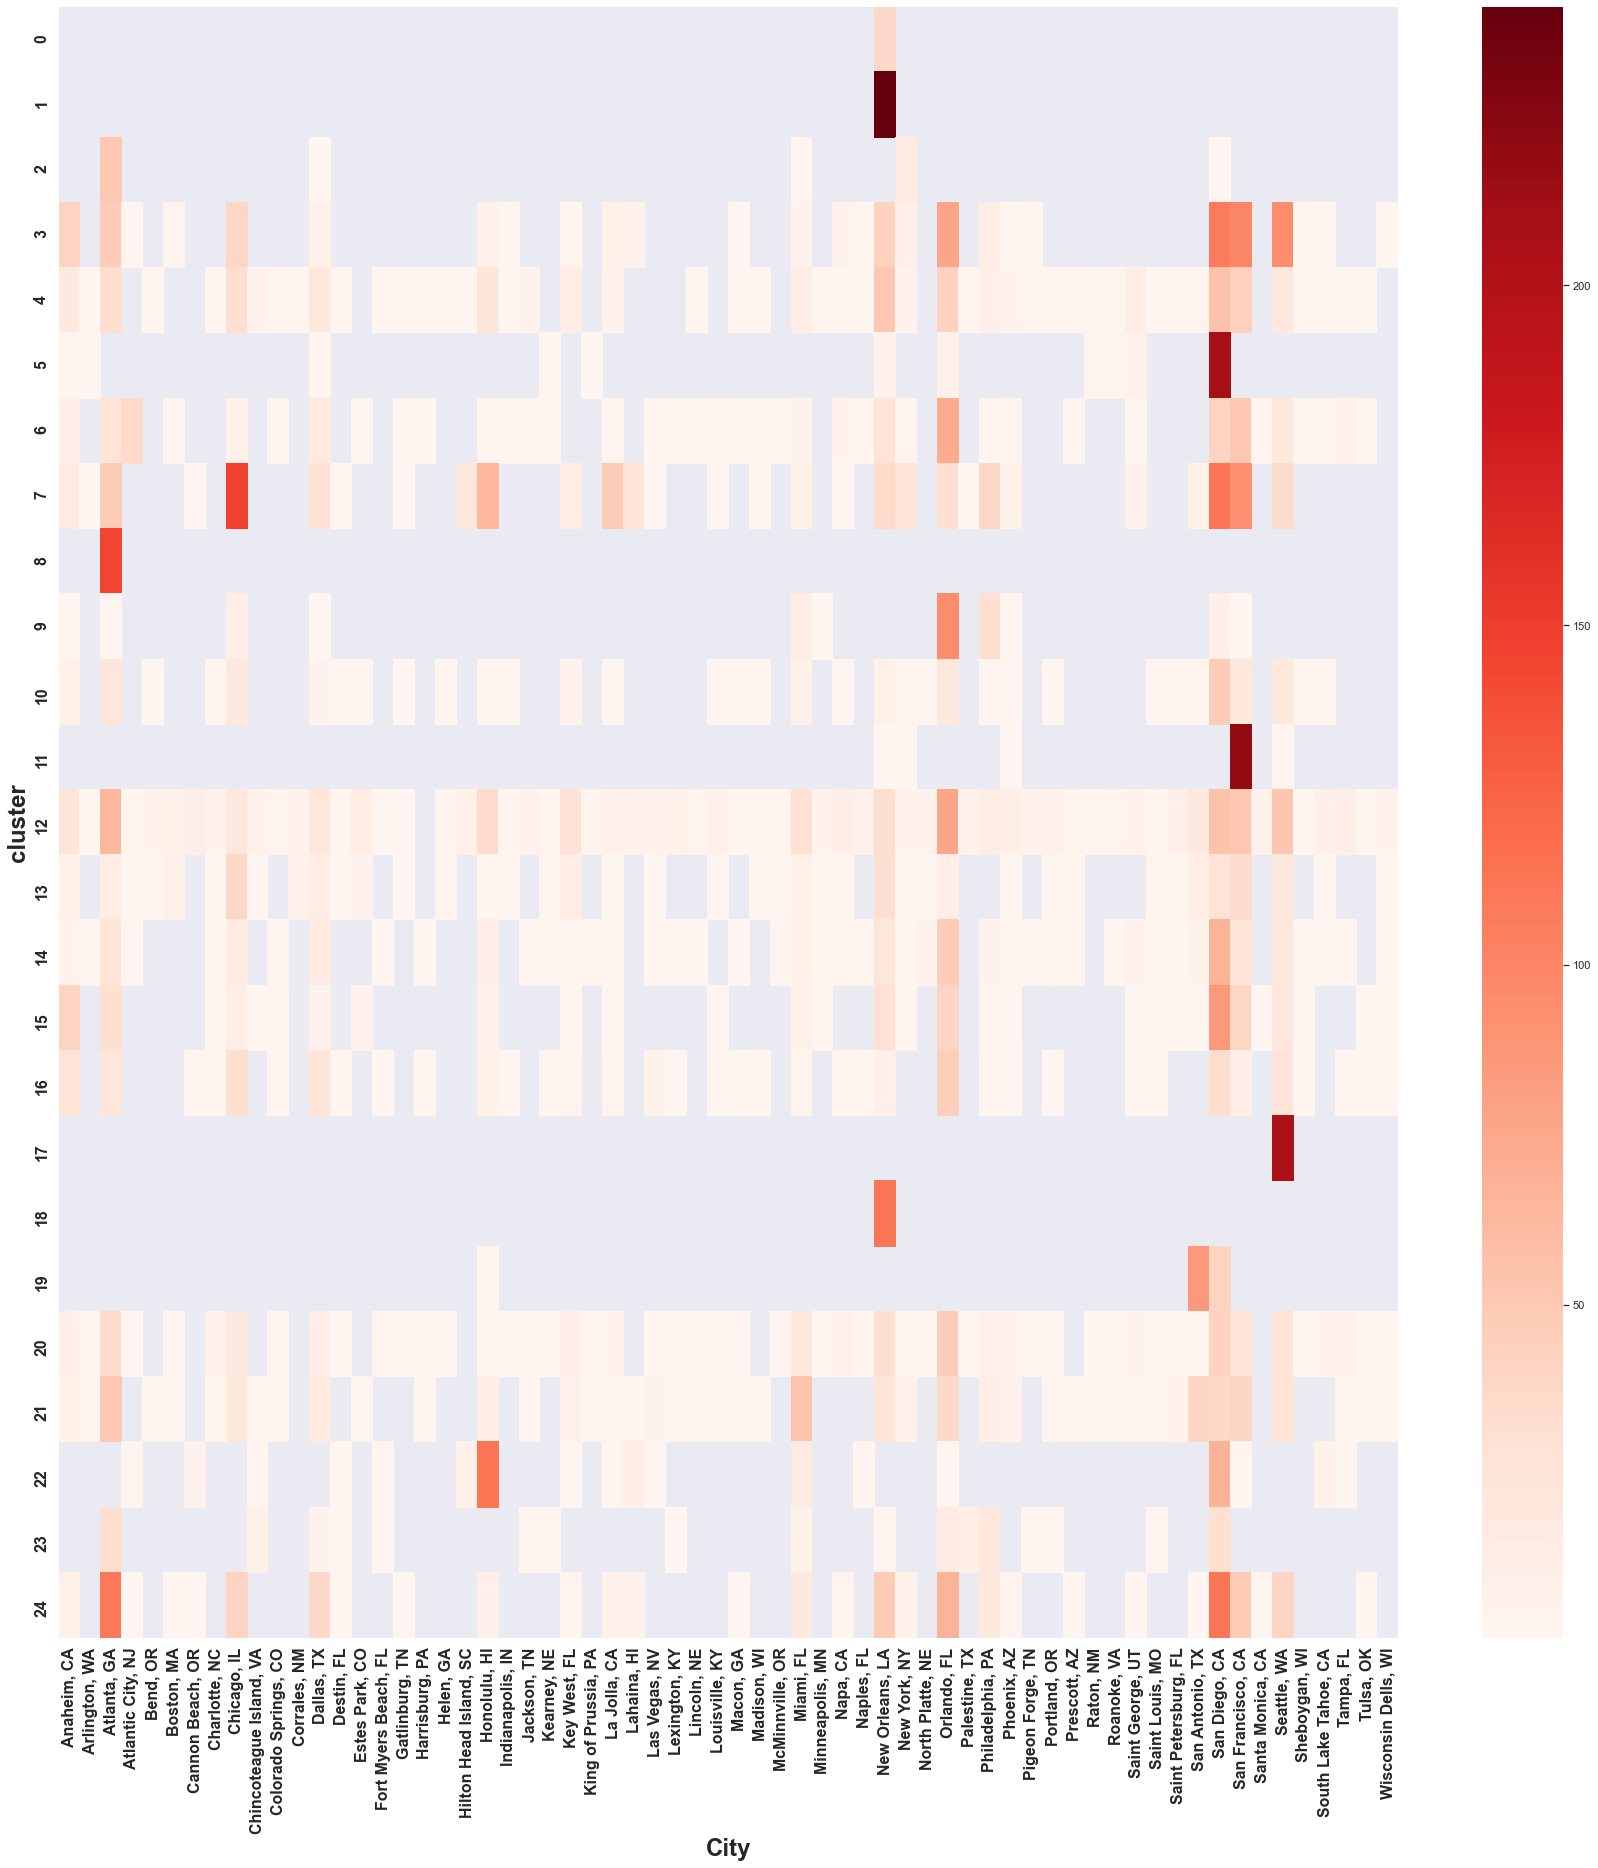

In [16]:
### Checking for association around City + State

clusters = cutoff.groupby(['cluster', 'city_and_state']).size()
fig2, ax2 = plt.subplots(figsize = (30, 30))
sns.heatmap(clusters.unstack(level = 'city_and_state'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('City', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")
plt.savefig("001.png")

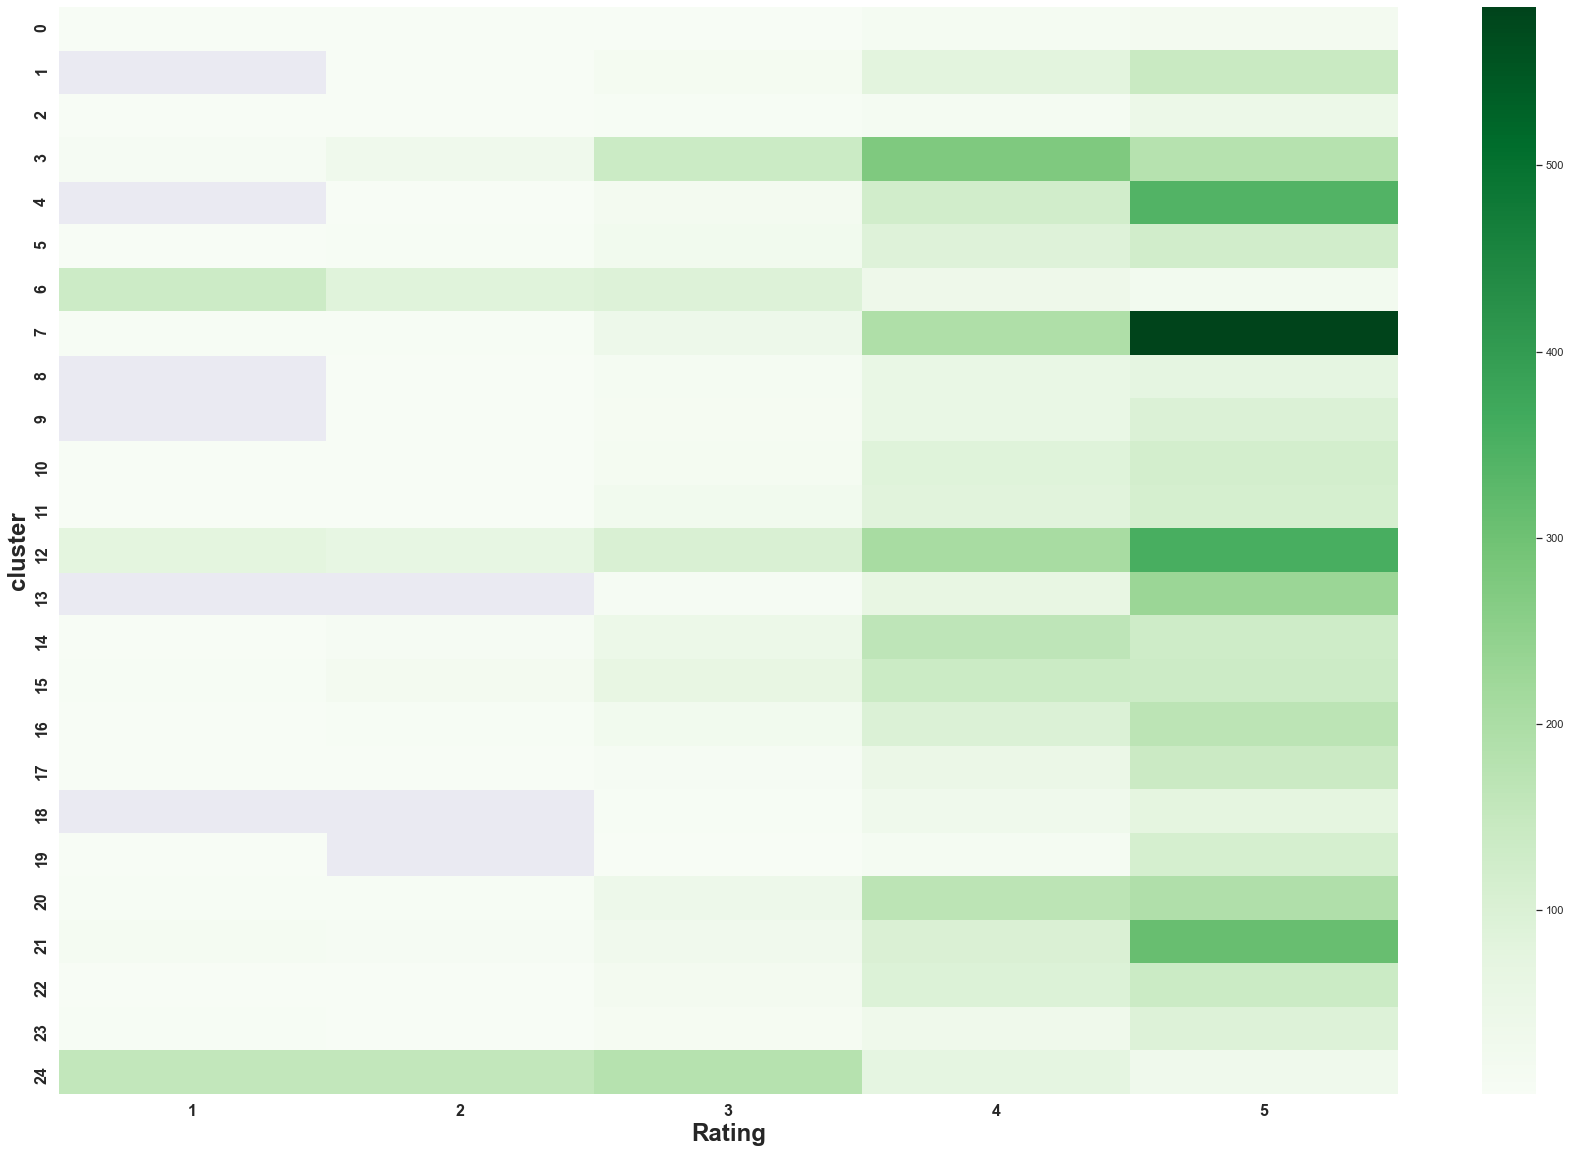

In [20]:
### Checking for association around Ratings

clusters = cutoff.groupby(['cluster', 'reviews_rating']).size()
fig2, ax2 = plt.subplots(figsize = (30, 20))
sns.heatmap(clusters.unstack(level = 'reviews_rating'), ax = ax2, cmap = 'Greens')

ax2.set_xlabel('Rating', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")
plt.savefig("002.png")


In [21]:
### Reviews skew overwhelmingly positive, so it makes sense that it would be heavily weighted in that direction

targetset["reviews_rating"].value_counts()

5    4840
4    2849
3    1190
1     567
2     554
Name: reviews_rating, dtype: int64

In [23]:
cutoff["address"].value_counts()

201 5th Ave N             209
136 E Grayson St          183
509 Decatur St            144
330 Magazine St           136
721 Pine Street           135
                         ... 
2240 Buena Vista Rd         1
1726 Prytania St            1
533 Clayton Rd              1
161 Powell Street           1
5142 W Point Loma Blvd      1
Name: address, Length: 410, dtype: int64

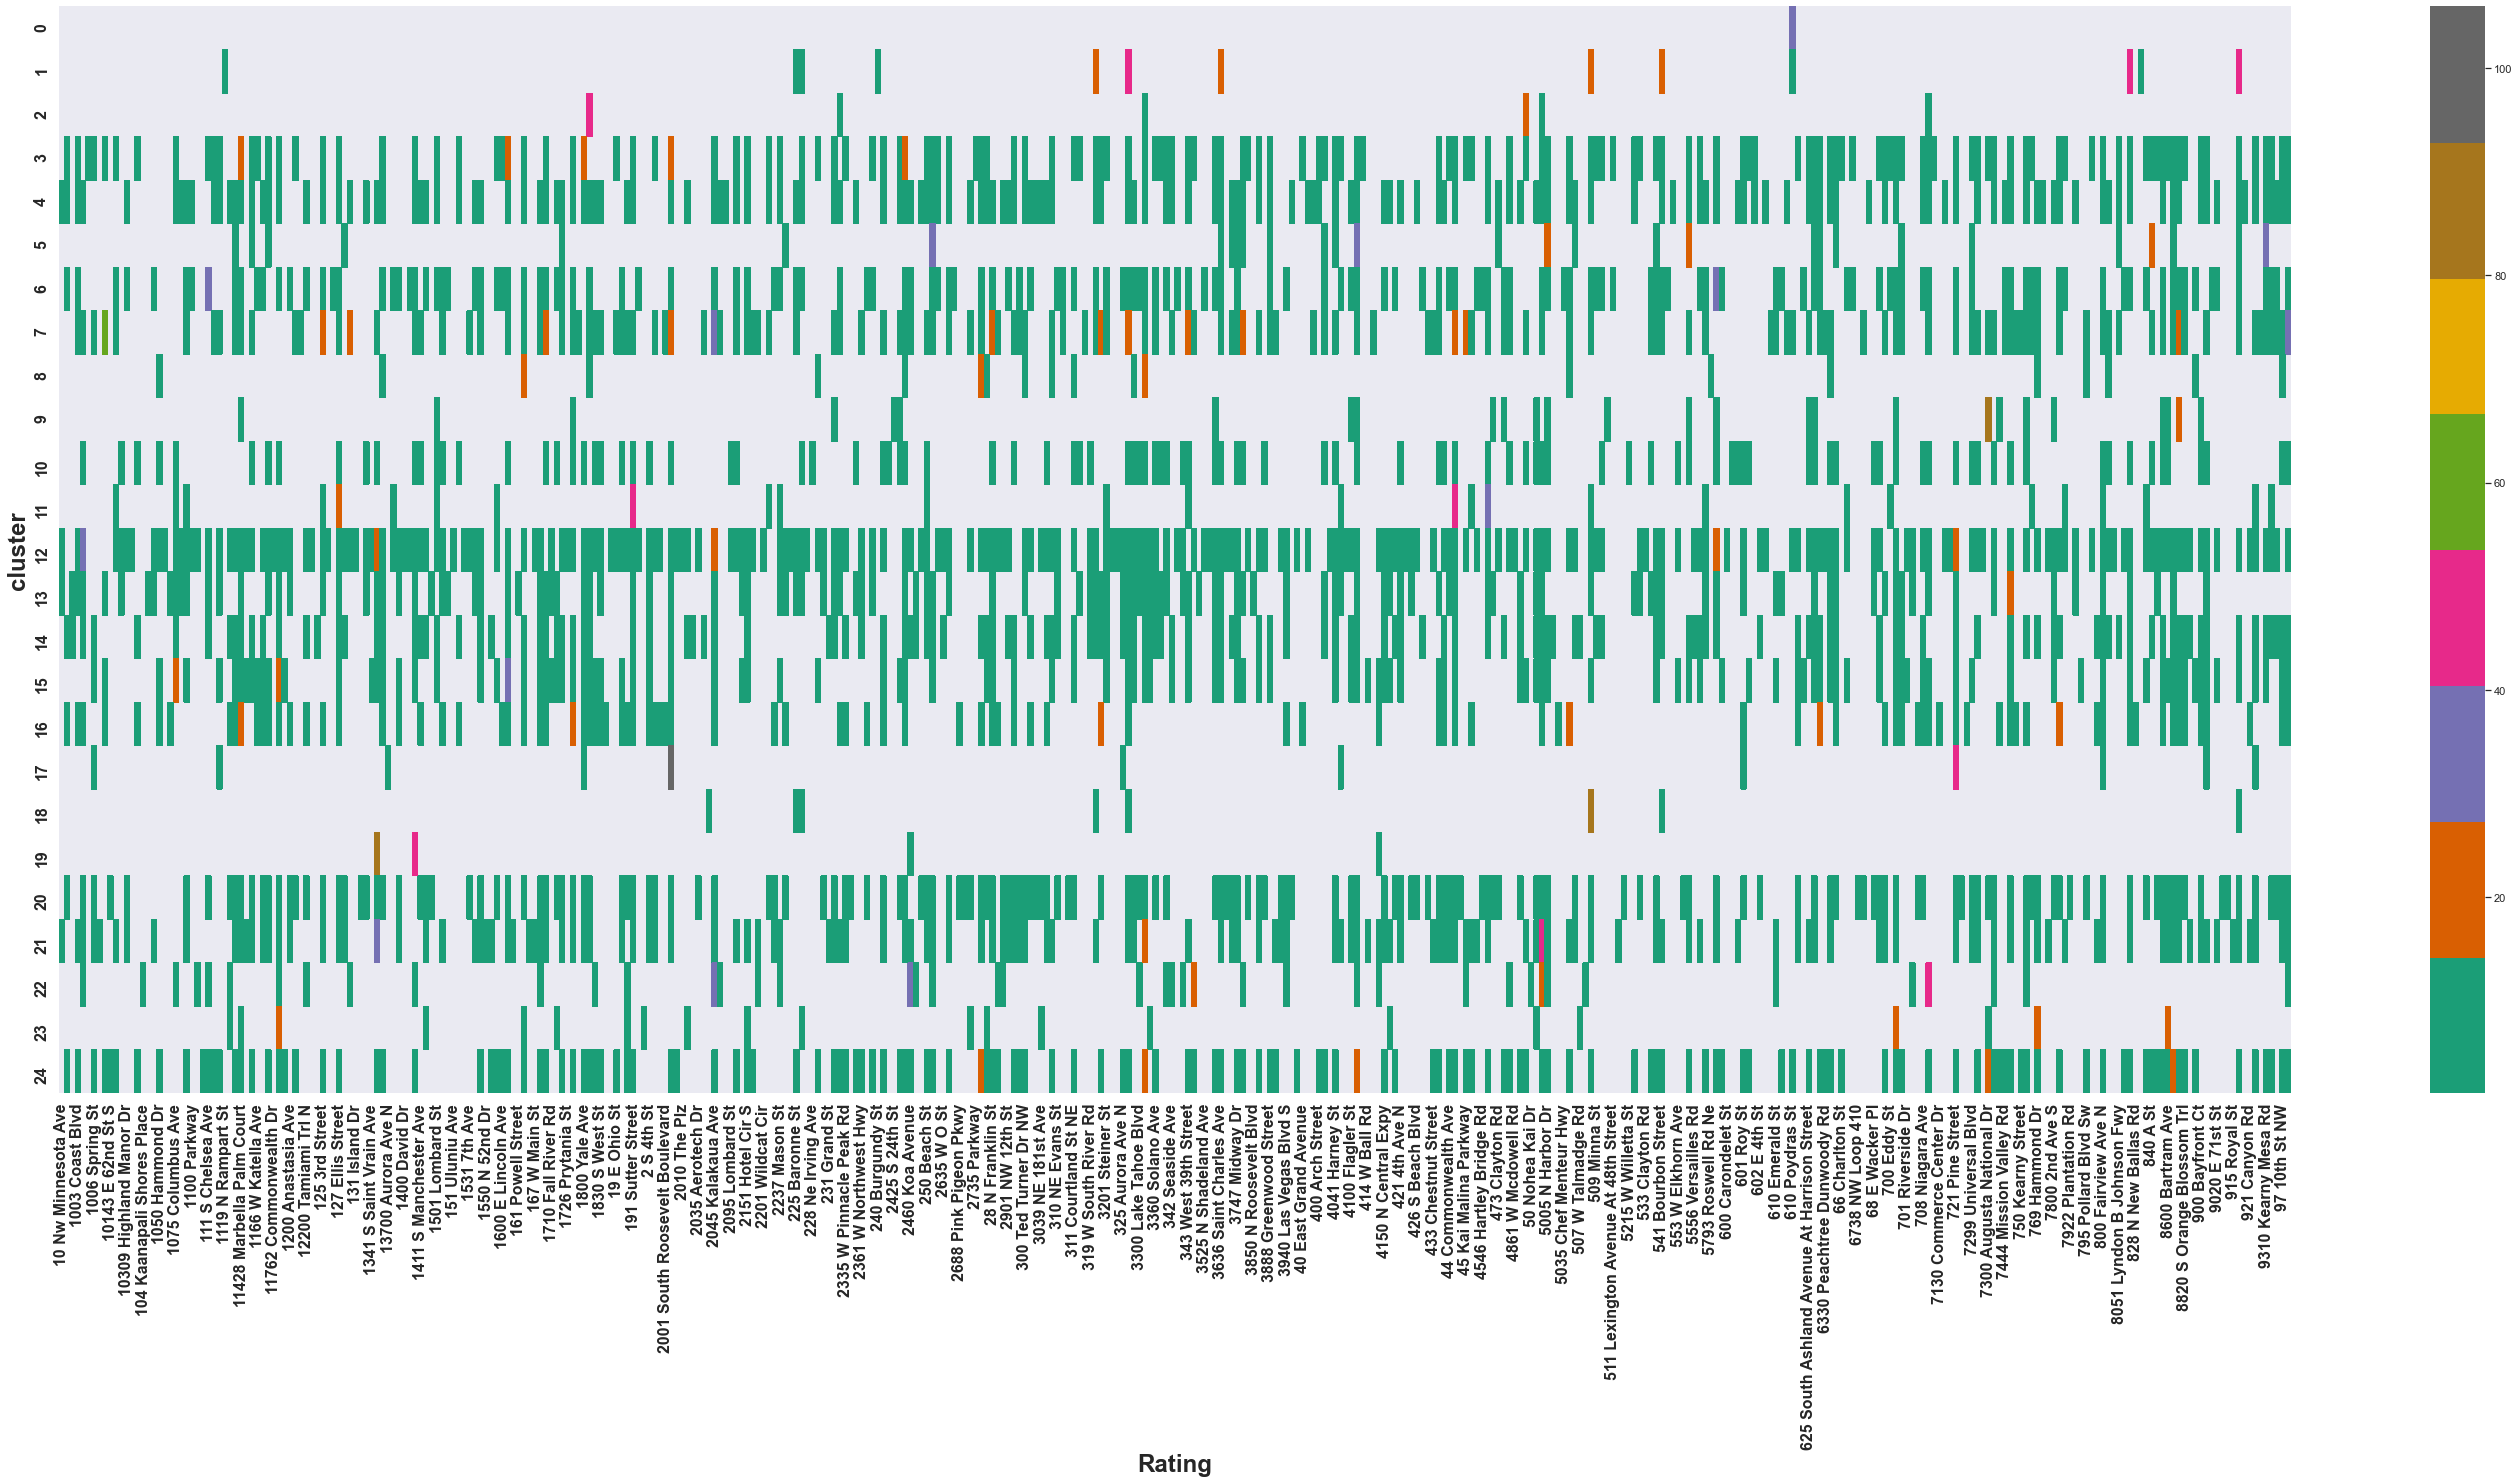

In [27]:
### DEPRECATED, DO NOT USE ###

# clusters = cutoff.groupby(['cluster', 'address']).size()
# fig2, ax2 = plt.subplots(figsize = (50, 20))
# sns.heatmap(clusters.unstack(level = 'address'), ax = ax2, cmap = 'Dark2')

# ax2.set_xlabel('Rating', fontdict = {'weight': 'bold', 'size': 24})
# ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
# for label in ax2.get_xticklabels():
#     label.set_size(16)
#     label.set_weight("bold")
# for label in ax2.get_yticklabels():
#     label.set_size(16)
#     label.set_weight("bold")
# plt.savefig("003.png")

In [416]:
### Reassociating the most common clustered words with specific hotels

df2 = cutoff[['cluster','address','city_and_state']].copy()
df2 = df2.groupby(['address','cluster'])['city_and_state'].count()
df2 = df2.reset_index()

In [417]:
df2['city_and_state'] = df2['city_and_state'].apply(str)
df2["address + count"] = df2["address"] + "_" + df2["city_and_state"]

In [418]:
df3 = pd.DataFrame(df2.groupby(["address"])["city_and_state"].max())

In [419]:
df3 = df3.reset_index(level=0)
df3["city_and_state"] = df3["city_and_state"].apply(str)
df3["address + count"] = df3["address"] + "_" + df3["city_and_state"]

In [421]:
df4 = df3.merge(df2, on=[('address + count')], how='inner')

In [422]:
df4 = df4.drop(columns=['city_and_state_x','address + count', 'address_y','city_and_state_y']).rename(columns={'address_x': 'address'})


In [424]:
df4["cluster"] = df4["cluster"].apply(str)
df4["cluster"]= df4["cluster"].replace(['0' , '1' , '2' , '3' , '4' , '5' , '6' , '7' , '8' , '9' , '10' , '11' , '12' , '13' , '14' , '15' , '16' , '17' , '18' , '19' , '20' , '21' , '22' , '23' , '24'],['whitney, callaisgener, casey, orlean, sincer, hotel, manag, visit, stay, forward' , 'quarter, french, hotel, orlean, room, street, stay, walk, great, bourbon' , 'ritz, carlton, stay, atlanta, hotel, servic, valet, room, great, club' , 'room, hotel, area, stay, night, breakfast, small, floor, walk, .the' , 'great, staff, help, stay, friend, hotel, clean, room, breakfast, locat' , 'western, diego, best, stay, hotel, thank, plus, room, staff, breakfast' , 'room, shower, bathroom, smell, hotel, door, water, dirti, stay, wall' , 'thank, stay, hotel, time, enjoy, review, great, staff, back, room' , 'atlanta, stay, hotel, downtown, staff, locat, great, room, buckhead, area' , 'airport, orlando, garden, hilton, shuttl, stay, hotel, servic, guest, managerhilton' , 'distanc, walk, within, restaur, hotel, locat, stay, great, room, nice' , 'union, squar, francisco, hotel, room, locat, stay, walk, great, staff' , 'room, stay, night, hotel, check, staff, book, clean, arriv, even' , 'love, place, perfect, great, stay, locat, room, hotel, river, staff' , 'good, breakfast, room, hotel, clean, staff, locat, stay, nice, friend' , 'park, free, hotel, room, stay, breakfast, great, clean, night, locat' , 'suit, room, stay, hotel, bedroom, great, thank, time, breakfast, famili' , 'seattl, hyatt, needl, space, stay, hotel, hous, jung, downtown, locat' , 'french, quarter, market, orlean, courtyard, histor, welcom, room, stay, locat' , 'emma, pearl, hotel, antonio, amaz, stay, great, beauti, uniqu, breweri' , 'nice, room, clean, hotel, stay, pool, breakfast, great, staff, comfort' , 'hotel, servic, stay, staff, great, room, recommend, locat, excel, restaur' , 'beach, waikiki, ocean, hotel, locat, stay, room, view, enjoy, resort' , 'hampton, stay, breakfast, hotel, staff, room, great, clean, area, philadelphia' , 'room, stay, guest, experi, hotel, apolog, time, sorri, desk, feedback'
])

In [425]:
df4 = df4.rename(columns={'cluster': 'keywords'})

In [426]:
df4

,address,keywords
0,10 Nw Minnesota Ave,"room, stay, night, hotel, check, staff, book, ..."
1,100 Soscol Ave,"nice, room, clean, hotel, stay, pool, breakfas..."
2,100 Soscol Ave,"room, stay, guest, experi, hotel, apolog, time..."
3,1001 White Spar Rd,"love, place, perfect, great, stay, locat, room..."
4,1001 White Spar Rd,"good, breakfast, room, hotel, clean, staff, lo..."
...,...,...
591,9310 Kearny Mesa Rd,"room, stay, guest, experi, hotel, apolog, time..."
592,940 Sutter Street,"thank, stay, hotel, time, enjoy, review, great..."
593,943 S Van Ness Ave,"good, breakfast, room, hotel, clean, staff, lo..."
594,97 10th St NW,"thank, stay, hotel, time, enjoy, review, great..."


In [427]:
df4.to_csv ("output/Keywords_by_address.csv")